In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback

import torch
from torch import nn

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, RecurrentNetwork
from pytorch_forecasting.metrics.quantile import QuantileLoss
import pytorch_forecasting.metrics

import pandas as pd

import matplotlib.pyplot as plt

In [4]:
# Load Data
data = pd.read_csv("1866_2022_3.csv")
#data = datas[datas["Source"] == 3]
n = len(data)
time_idx = [i for i in range(n)]
data.insert(3, "Time", time_idx, True)
data["Date"] = data["Date"].astype(str)
#data = data.drop("Date", axis = 1)
#data = data.drop("Source", axis=1)

data = data[:200_000]
print(data)
print(type(data["Date"][0]))

                       Date  Valeur  Source    Time
0       10/08/1995 11:50:00    3.05       3       0
1       10/08/1995 12:00:00    3.30       3       1
2       10/08/1995 12:10:00    3.55       3       2
3       10/08/1995 12:20:00    3.80       3       3
4       10/08/1995 12:30:00    4.07       3       4
...                     ...     ...     ...     ...
199995  06/01/1999 12:30:00    1.91       3  199995
199996  06/01/1999 12:40:00    1.86       3  199996
199997  06/01/1999 12:50:00    1.77       3  199997
199998  06/01/1999 13:00:00    1.75       3  199998
199999  06/01/1999 13:10:00    1.69       3  199999

[200000 rows x 4 columns]
<class 'str'>


In [5]:
# define dataset
max_encoder_length = 100
max_prediction_length = 10

In [6]:
training_cutoff = data["Time"].max() - max_prediction_length
print(training_cutoff)
#print(data[lambda x: x.Time <= training_cutoff])
training = TimeSeriesDataSet(
    data[lambda x: x.Time <= training_cutoff],
    time_idx= "Time",
    target= "Valeur",
    group_ids=["Source"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Date"],
    static_reals=["Source"],
    categorical_encoders = {'Date' : pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True, warn = False)},
    time_varying_known_categoricals=["Date"],
    time_varying_known_reals=["Time"],
    time_varying_unknown_reals=["Valeur"],
)
print(training)

199989
TimeSeriesDataSet[length=199881](
	time_idx='Time',
	target='Valeur',
	group_ids=['Source'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=0,
	min_prediction_length=10,
	max_prediction_length=10,
	static_categoricals=['Date'],
	static_reals=['Source'],
	time_varying_known_categoricals=['Date'],
	time_varying_known_reals=['Time'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Valeur'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'Date': NaNLabelEncoder(add_nan=True, warn=False), '__group_id__Source': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'Source': StandardScaler(), 'Time': StandardScaler()},
	randomize_length=None,
	predi

In [7]:
# create validation and training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)
print(validation)

TimeSeriesDataSet[length=110](
	time_idx='Time',
	target='Valeur',
	group_ids=['Source'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=199881,
	min_prediction_length=10,
	max_prediction_length=10,
	static_categoricals=['Date'],
	static_reals=['Source'],
	time_varying_known_categoricals=['Date'],
	time_varying_known_reals=['Time'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Valeur'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'Date': NaNLabelEncoder(add_nan=True, warn=False), '__group_id__Source': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'Source': StandardScaler(), 'Time': StandardScaler()},
	randomize_length=None,
	predict_mo

In [8]:
class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is starting !")
        print("======================")
    def on_train_end(self, trainer, pl_module):
        print("=================")
        print("Training is done.")

In [9]:
# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", patience=2, verbose=2, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback, PrintCallback()],
    accelerator = 'gpu',
    devices = 1,
    auto_lr_find = False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=4,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=1,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Number of parameters in network: 1604.8k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:826: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /mnt/c/Users/alex4/Desktop/COURS/PIIA-Marees/PyTorch/.lr_find_89127163-2f33-479c-8331-2de8f55c7b9f.ckpt


KeyError: 'radam_buffer'

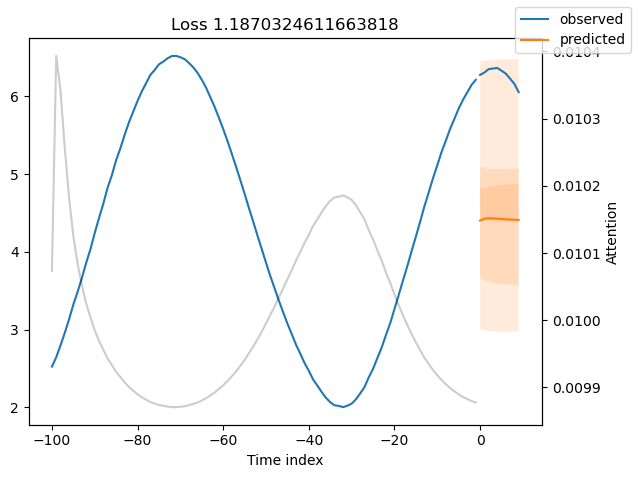

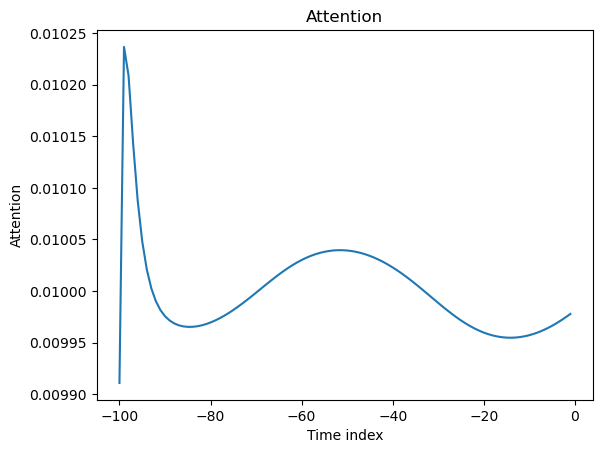

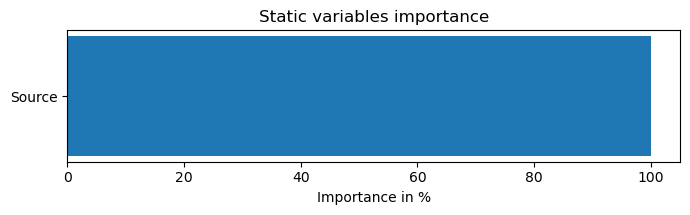

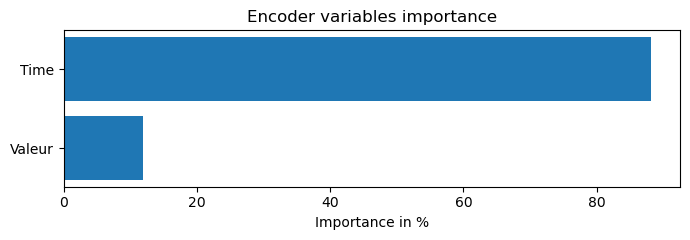

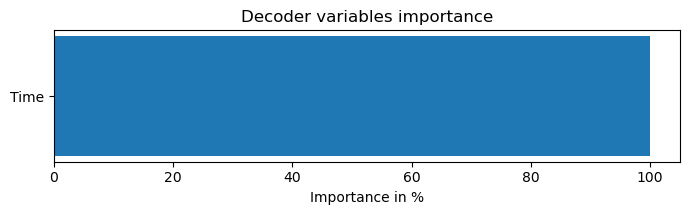

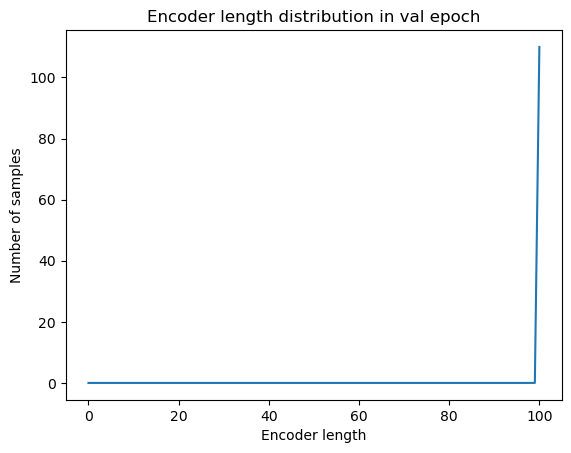

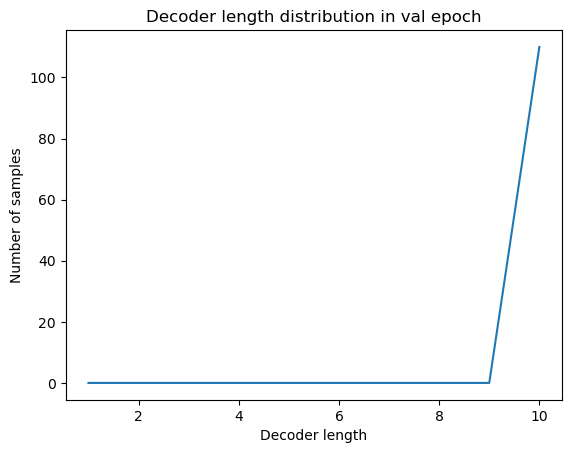

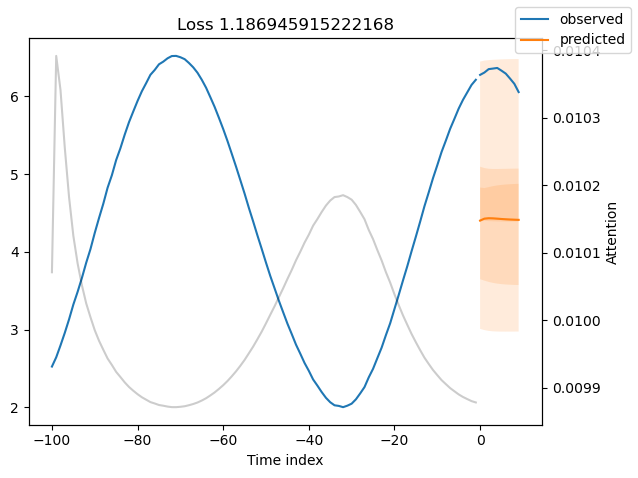

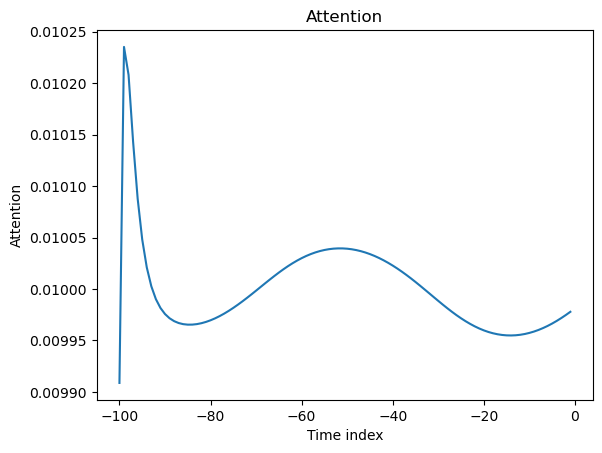

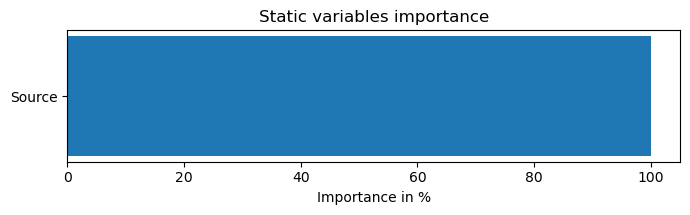

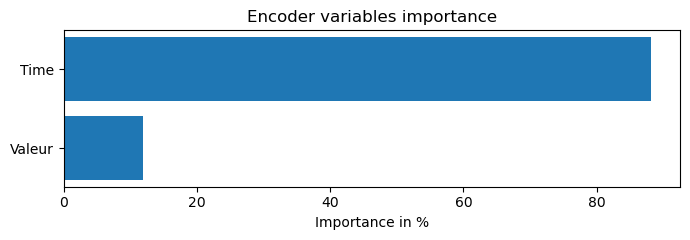

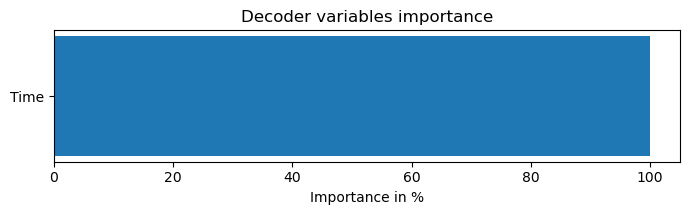

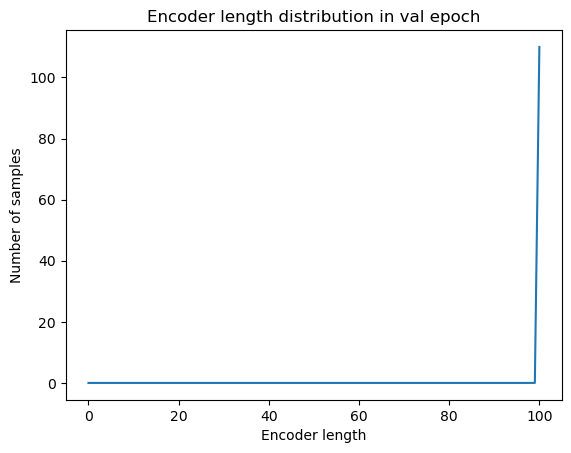

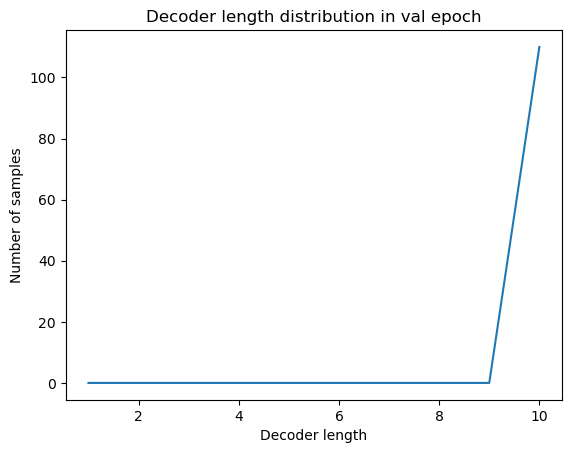

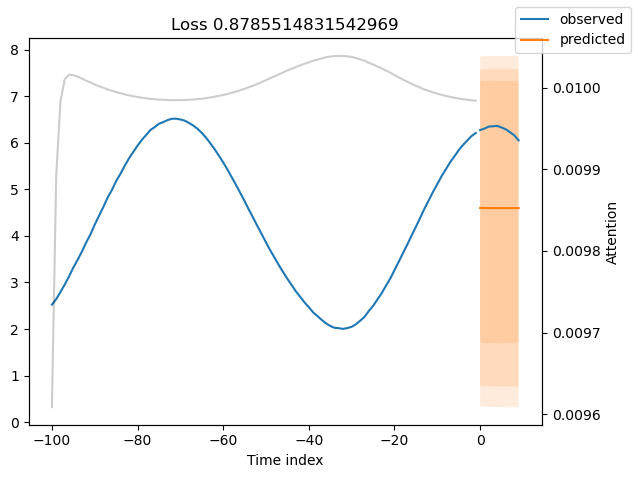

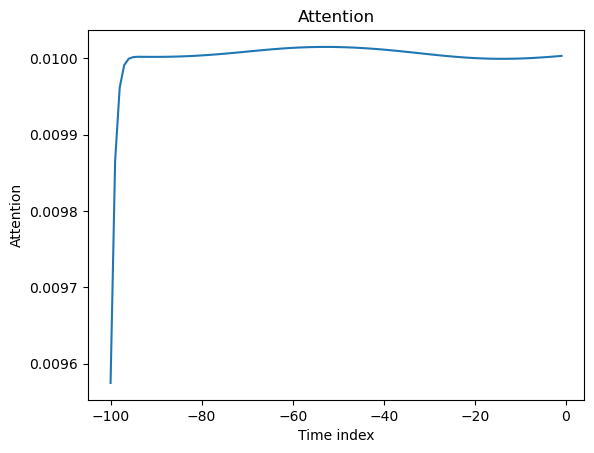

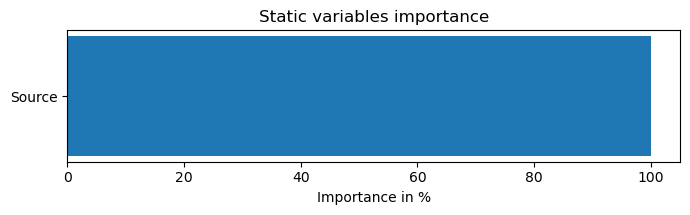

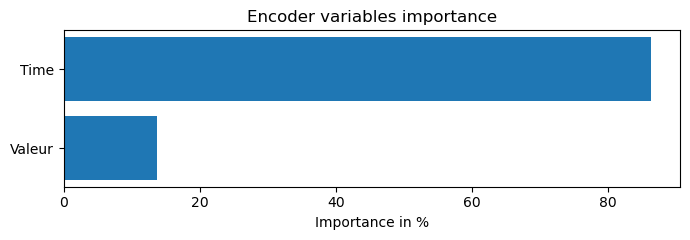

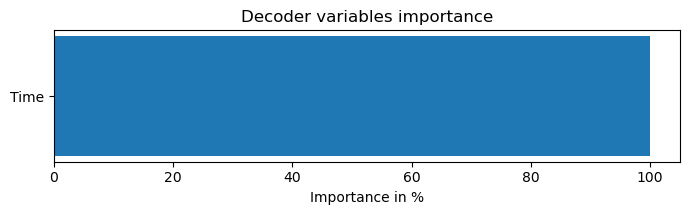

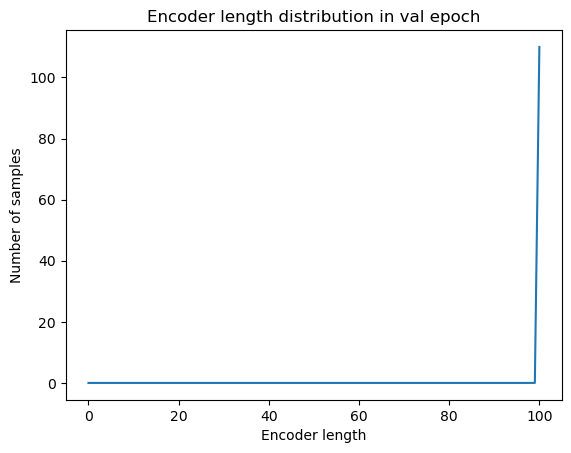

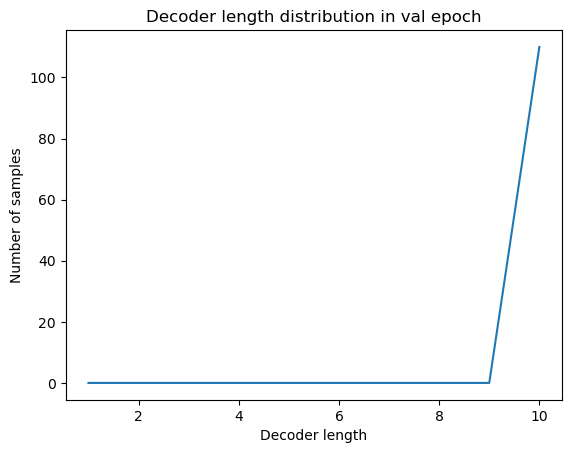

In [13]:
# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = trainer.tuner.lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [11]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.6 M 
3  | prescalers                         | ModuleDict                      | 24    
4  | static_variable_selection          | VariableSelectionNetwork        | 246   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 486   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 262   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training is starting !


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.042


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 0.779


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.733


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.307 >= min_delta = 0.0. New best score: 0.426


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.191 >= min_delta = 0.0. New best score: 0.234


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.158


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.144


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.103


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.086


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.086


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.077


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.069


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 2 records. Best score: 0.069. Signaling Trainer to stop.


Training is done.


AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

In [12]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [13]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
print((actuals - predictions).abs().mean())

tensor(0.1303)


In [14]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

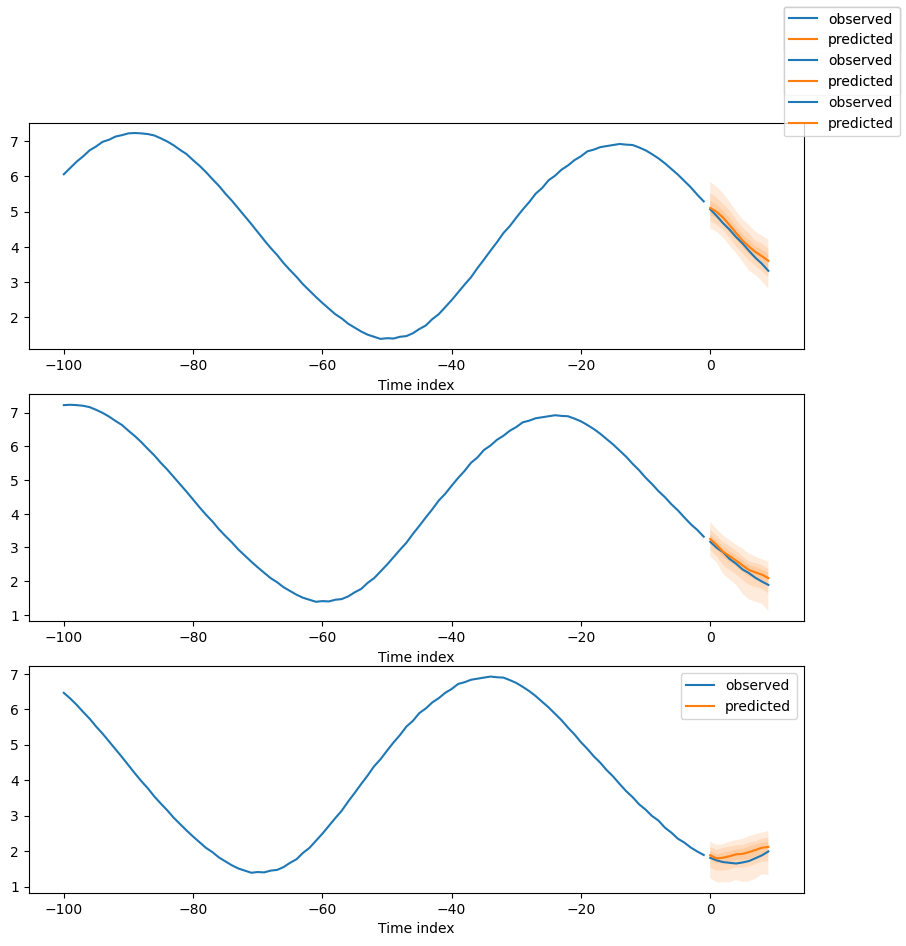

In [15]:
fig, ax = plt.subplots(3,1, figsize=(10,10))
for idx in range(0,30,10):  # plot 10 examples
    i=0
    ax1 = ax[idx//10]
    best_tft.plot_prediction(x, raw_predictions,ax=ax1, idx=idx+20, plot_attention=False);
    
plt.legend()

### Actual VS Predictions

/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/home/alex/miniconda3/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6


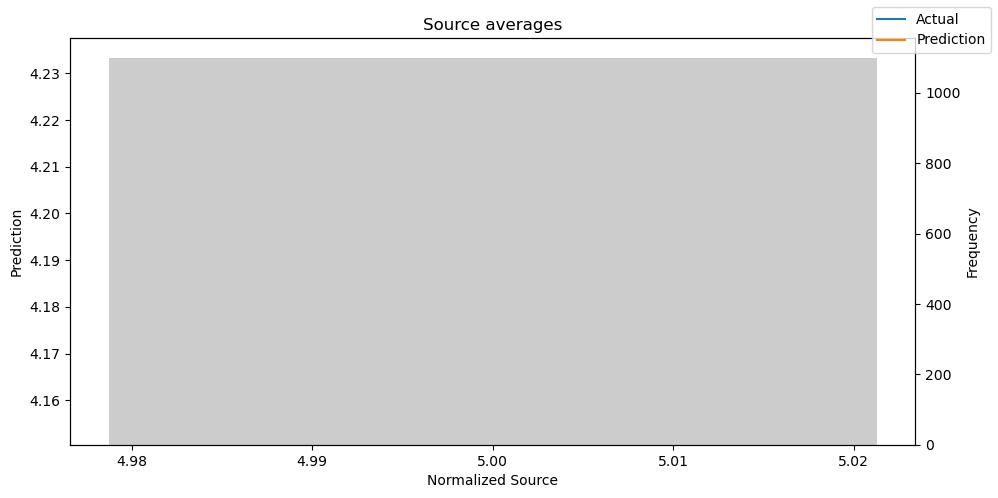

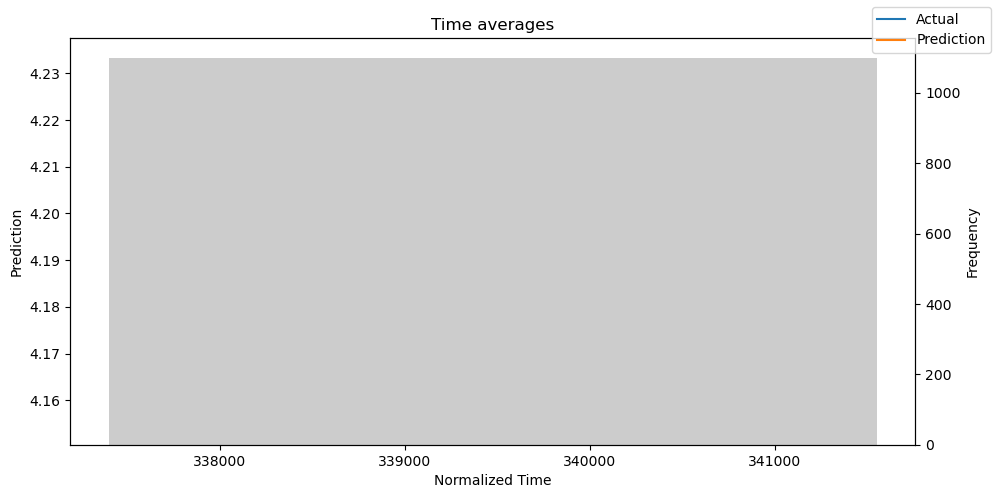

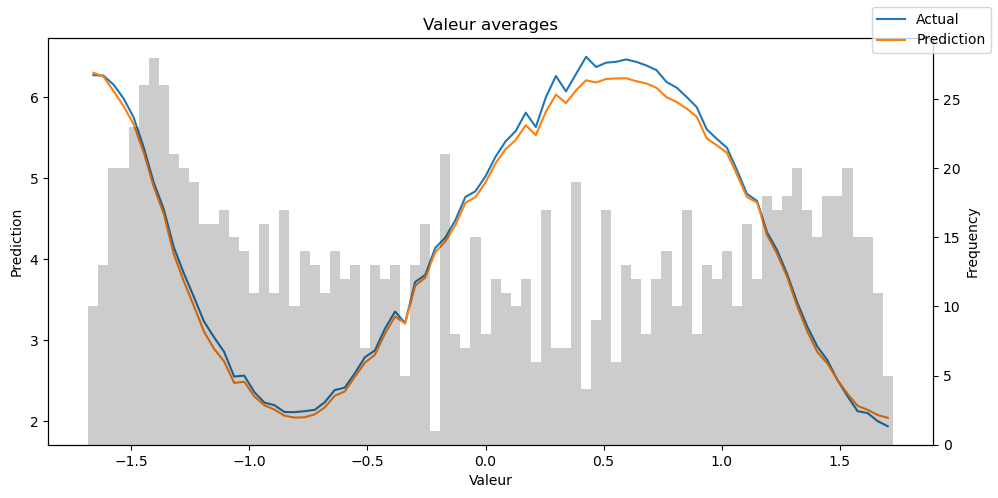

In [14]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

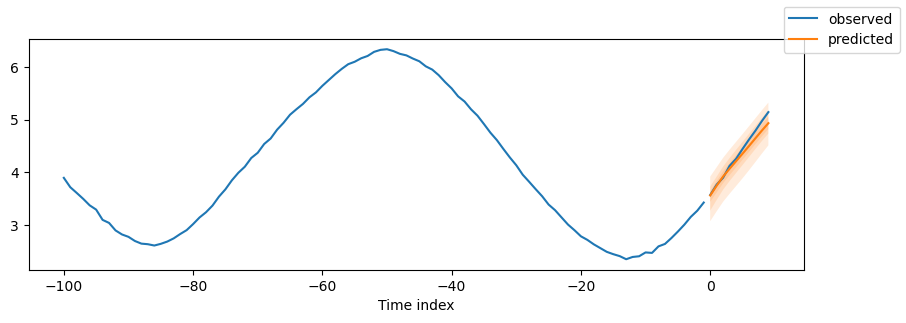

In [15]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: x.time_idx_first_prediction == 1000),
    mode="raw",
    return_x=True,
)

fig, ax = plt.subplots(1,1,figsize=(10,3))
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax, plot_attention = False);